In [1]:
from SyNBEATS import *
import pandas as pd

dta = pd.read_csv("smoking_data.csv")
dta = dta[["state", "year", "cigsale"]]
dta.columns = ["id", "year", "Y_obs"]
dta.loc[:,'year'] = pd.to_datetime(dta['year'], format="%Y")

model = SyNBEATS(dta, [3], 1989)

In [2]:
prediction = model.forecast()
prediction

INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.3 M 
---------------------------------------------------
6.3 M     Trainable params
1.5 K     Non-trainable params
6.3 M     Total params
25.278    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

<TimeSeries (DataArray) (year: 12, component: 1, sample: 1)>
array([[[91.30981432]],

       [[86.49286967]],

       [[78.73464258]],

       [[78.69278471]],

       [[78.24212855]],

       [[76.73372704]],

       [[72.72785446]],

       [[74.03790844]],

       [[73.4702778 ]],

       [[72.50494402]],

       [[72.38854348]],

       [[69.69130448]]])
Coordinates:
  * year       (year) datetime64[ns] 1989-01-01 1990-01-01 ... 2000-01-01
  * component  (component) object 'Y_obs'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

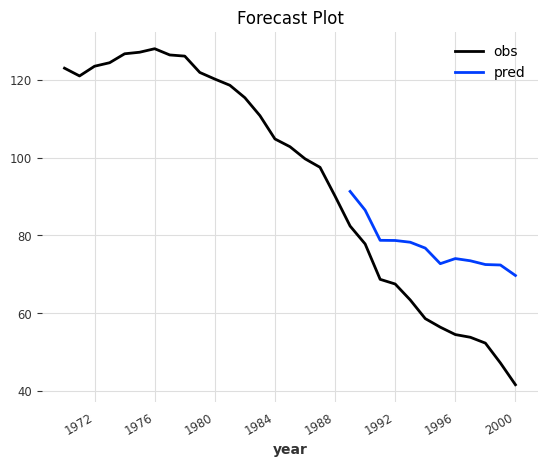

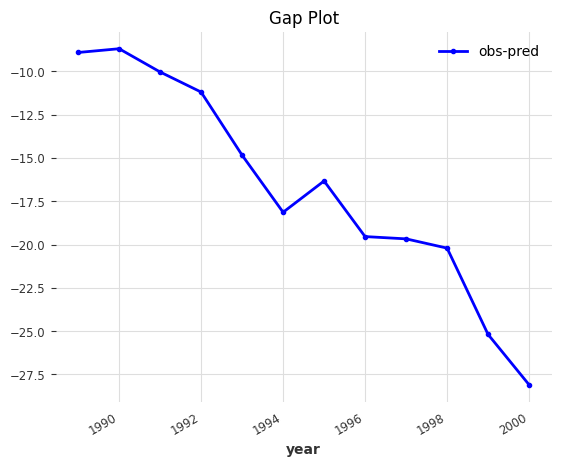

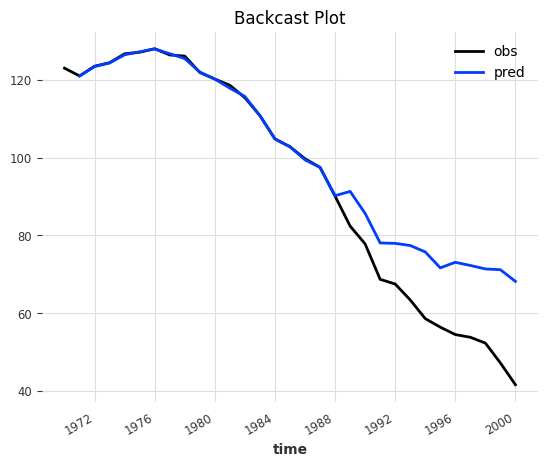

In [3]:
model.plot_forecast()
model.plot_gap()
model.plot_backcast()

In [4]:
ate = model.average_treatment_effect()
std = model.std_treatment_effect()
ate, std

(-16.735566566331773, 6.028863084067825)

In [6]:
placebo_effects = model.placebo_test(control_ids=range(4,15))
placebo_effects
significant, p_value = model.check_significance(placebo_effects, alpha=0.05)
significant, p_value


Starting the placebo test...


Processing placebo for control id 14: 100%|██████████| 11/11 [08:48<00:00, 48.02s/it]

Placebo test completed.


(True, 0.013681243955139144)